In [5]:
import pandas as pd

data = pd.read_csv('/Users/sohampurushan/Documents/GitHub/Thena-Risk-Models/Data/impermanent_loss_data.csv')


data['significant_il_event'] = (data['impermanent_loss'] > 0.05).astype(int)

# Save updated CSV
data.to_csv('impermanent_loss_data_with_events.csv', index=False)

# Display summary
print("Number of significant IL events:", data['significant_il_event'].sum())
print("Percentage of significant events:", (data['significant_il_event'].mean() * 100).round(2), "%")

Number of significant IL events: 134
Percentage of significant events: 74.03 %


In [13]:
#Some more cleaning
import numpy as np
from sklearn.impute import KNNImputer

data1 = pd.read_csv('/Users/sohampurushan/Documents/GitHub/Thena-Risk-Models/impermanent_loss_data_with_events.csv')
numeric_cols = data1.select_dtypes(include=[np.number]).columns

print("Missing values per column:")
print(data1[numeric_cols].isnull().sum())

valid_numeric_cols = data1[numeric_cols].columns[data1[numeric_cols].isnull().mean() < 1]
print("\nColumns with valid data:", len(valid_numeric_cols))
print(valid_numeric_cols.tolist())

# Apply KNN imputation only on valid columns
imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(data1[valid_numeric_cols])
data_new = pd.DataFrame(imputed_array, columns=valid_numeric_cols)

data1[valid_numeric_cols] = data_new

# Fill remaining numeric columns with 0
remaining_numeric_cols = set(numeric_cols) - set(valid_numeric_cols)
data1[list(remaining_numeric_cols)] = 0

print("\nFinal data shape:", data1.shape)

# Save cleaned data
data1.to_csv('impermanent_loss_data_cleaned.csv', index=False)


Missing values per column:
ethereum_current_price_usd           0
ethereum_market_cap_usd              0
ethereum_total_volume_usd            0
ethereum_facebook_likes            181
ethereum_twitter_followers          30
ethereum_reddit_subscribers        181
ethereum_alexa_rank                181
ethereum_forks                     181
ethereum_stars                     181
ethereum_subscribers               181
ethereum_total_issues              181
binance coin_current_price_usd       0
binance coin_market_cap_usd          0
binance coin_total_volume_usd        0
binance coin_facebook_likes        181
binance coin_twitter_followers      30
binance coin_reddit_subscribers    181
binance coin_alexa_rank            181
binance coin_forks                 100
binance coin_stars                 100
binance coin_subscribers           100
binance coin_total_issues          100
tvlUsd                               0
apy                                  0
apyBase                              

Clean shape: (175, 4)

First few rows:
   ETH_Weekly_Mean  ETH_Weekly_Std  BNB_Weekly_Mean  BNB_Weekly_Std
0      3032.596582       59.676606       511.588082       13.448042
1      3037.317557       64.177835       513.227936       14.446227
2      3058.543663       68.203041       518.252931       14.635323
3      3073.866062       81.058705       518.877710       15.177037
4      3120.159341       76.686516       526.748534       11.478075


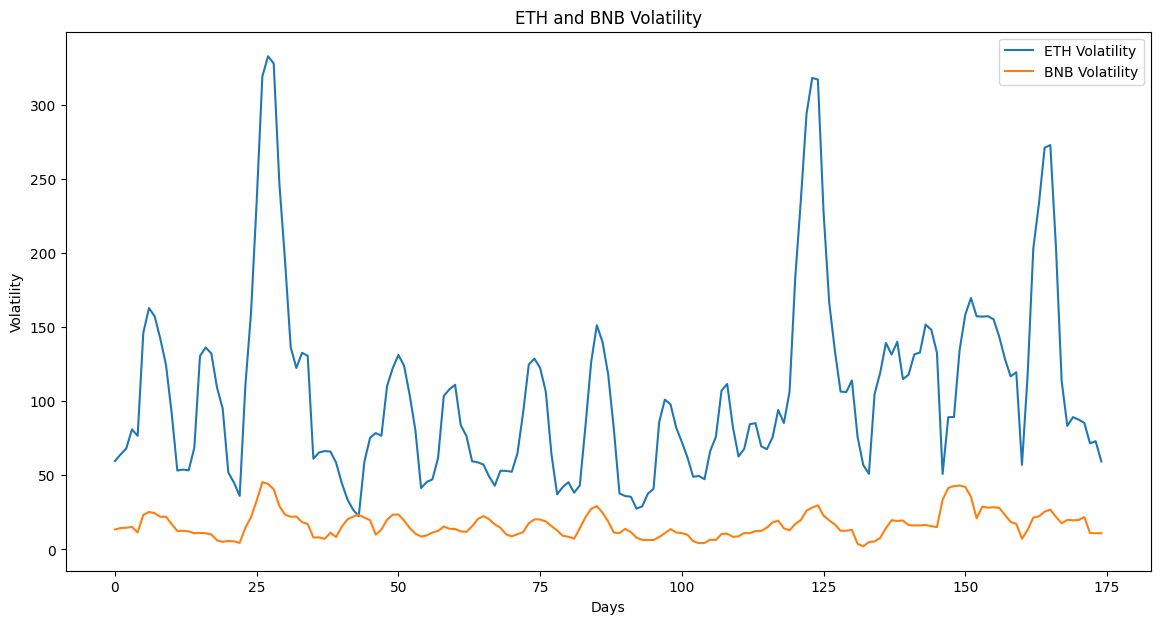

In [17]:
import matplotlib.pyplot as plt

window = 7

data1['ETH_Weekly_Mean'] = data1['ethereum_current_price_usd'].rolling(window=window).mean()
data1['ETH_Weekly_Std'] = data1['ethereum_current_price_usd'].rolling(window=window).std()

data1['BNB_Weekly_Mean'] = data1['binance coin_current_price_usd'].rolling(window=window).mean()
data1['BNB_Weekly_Std'] = data1['binance coin_current_price_usd'].rolling(window=window).std()


PriceAnalysis = data1[['ETH_Weekly_Mean', 'ETH_Weekly_Std', 'BNB_Weekly_Mean', 'BNB_Weekly_Std']]

PriceAnalysis = PriceAnalysis.dropna()
PriceAnalysis = PriceAnalysis.reset_index(drop=True)

print("Clean shape:", PriceAnalysis.shape)
print("\nFirst few rows:")
print(PriceAnalysis.head())


plt.figure(figsize=(14, 7))
plt.plot(PriceAnalysis['ETH_Weekly_Std'], label='ETH Volatility')

plt.plot(PriceAnalysis['BNB_Weekly_Std'], label='BNB Volatility')

plt.xlabel('Days')
plt.ylabel('Volatility')
plt.title('ETH and BNB Volatility')
plt.legend()
plt.show()

In [78]:
print("Data shape:", data1.shape)
print("\nFirst few dates:")
print(data1['date'].head())
print("\nLast few dates:")
print(data1['date'].tail())

total_days = len(data1)
expected_windows = total_days - window + 1
print(f"\nTotal days: {total_days}")
print(f"Window size: {window}")
print(f"Expected complete windows: {expected_windows}")

data1['weekly_correlation'] = data1['ethereum_current_price_usd'].rolling(window=window).corr(data1['binance coin_current_price_usd'])

clean_data = data1.dropna(subset=['weekly_correlation'])
print(f"\nTotal correlations after cleaning: {len(clean_data)}")
print("\nCorrelation values:")
print(clean_data['weekly_correlation'].describe())

Data shape: (175, 32)

First few dates:
0    2024-07-11
1    2024-07-12
2    2024-07-13
3    2024-07-14
4    2024-07-15
Name: date, dtype: object

Last few dates:
170    2024-12-28
171    2024-12-29
172    2024-12-30
173    2024-12-31
174    2025-01-01
Name: date, dtype: object

Total days: 175
Window size: 7
Expected complete windows: 169

Total correlations after cleaning: 169

Correlation values:
count    169.000000
mean       0.761049
std        0.250313
min       -0.224736
25%        0.631410
50%        0.871138
75%        0.943387
max        0.998642
Name: weekly_correlation, dtype: float64


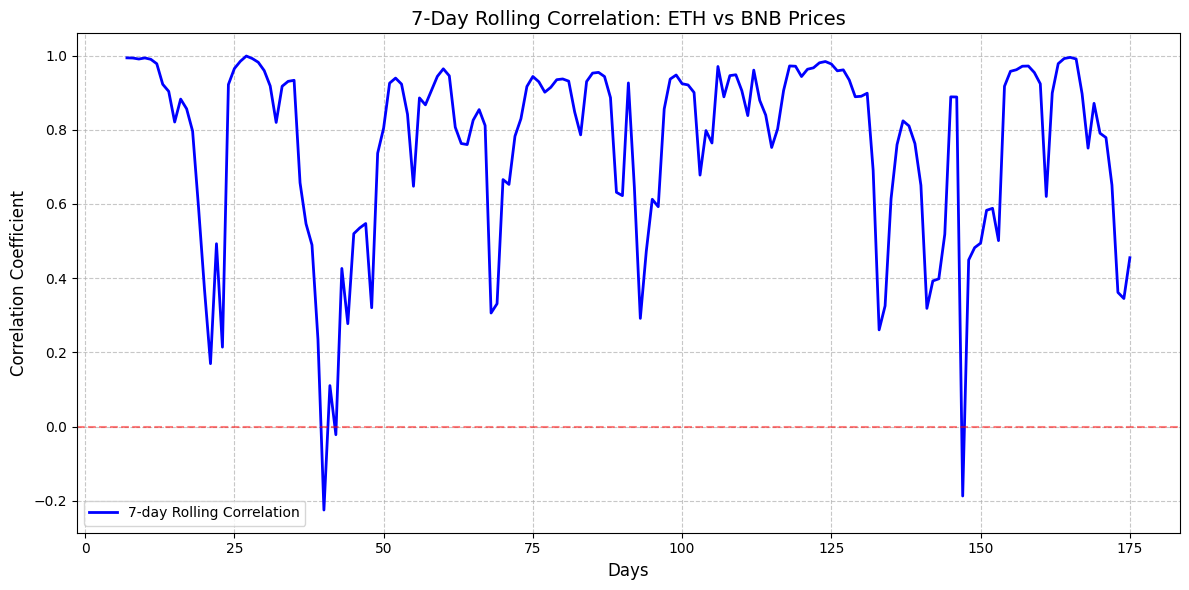

In [80]:
days = range(1, len(data1) + 1)

plt.figure(figsize=(12, 6))
plt.plot(days, data1['weekly_correlation'], 
         label='7-day Rolling Correlation', 
         color='blue', 
         linewidth=2)

plt.xlabel('Days', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.title('7-Day Rolling Correlation: ETH vs BNB Prices', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

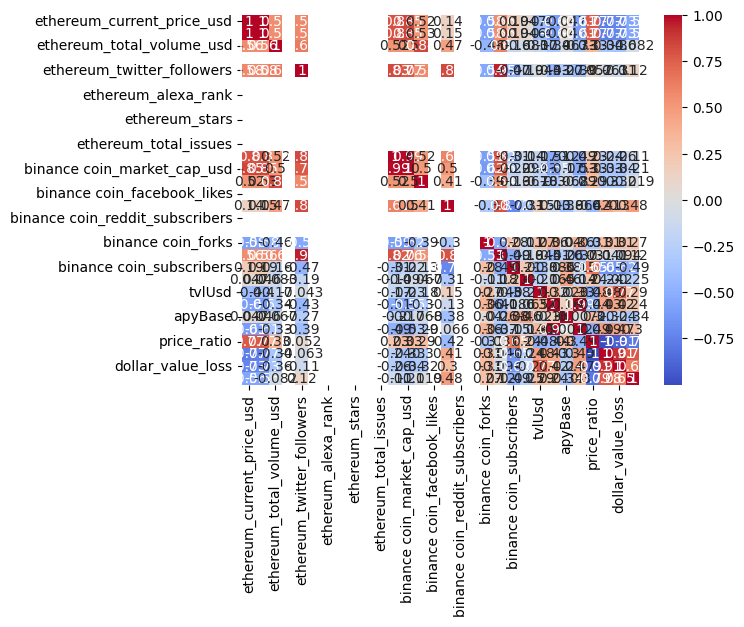

In [95]:
import seaborn as sns

data2 = data1.drop(['date', 'weekly_correlation'], axis=1)
correlation_matrix = data2.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()



In [96]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add constant to the predictors
predictors = add_constant(data2)

vif_data = pd.DataFrame()
vif_data["Feature"] = predictors.columns
vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

print(vif_data)


                            Feature           VIF
0                             const  0.000000e+00
1        ethereum_current_price_usd  5.521041e+04
2           ethereum_market_cap_usd  5.492224e+04
3         ethereum_total_volume_usd  5.372435e+00
4           ethereum_facebook_likes           NaN
5        ethereum_twitter_followers  2.107380e+01
6       ethereum_reddit_subscribers           NaN
7               ethereum_alexa_rank           NaN
8                    ethereum_forks           NaN
9                    ethereum_stars           NaN
10             ethereum_subscribers           NaN
11            ethereum_total_issues           NaN
12   binance coin_current_price_usd  7.213113e+02
13      binance coin_market_cap_usd  2.651163e+02
14    binance coin_total_volume_usd  4.026998e+00
15      binance coin_facebook_likes           NaN
16   binance coin_twitter_followers  2.373255e+01
17  binance coin_reddit_subscribers           NaN
18          binance coin_alexa_rank           NaN


/Users/sohampurushan/Documents/GitHub/Thena-Risk-Models/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/sohampurushan/Documents/GitHub/Thena-Risk-Models/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [ ]:
#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("Original data shape:", data2.shape)
print("\nColumns:", data2.columns.tolist())
print("\nMissing values:\n", data2.isnull().sum())

# Select only numeric columns and drop any rows with NaN
numeric_data = data2.select_dtypes(include=[np.number])
clean_data = numeric_data.dropna()
clean_data = clean_data.drop('significant_il_event', axis=1)

print("\nClean data shape:", clean_data.shape)


scaler = StandardScaler()
data_scaled = scaler.fit_transform(clean_data)

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

pca_df = pd.DataFrame(data=data_pca, columns=['PC1', 'PC2'])

print("\nPCA Results:")
print(pca_df.head())
print("\nExplained variance ratio:", pca.explained_variance_ratio_)

Original data shape: (175, 30)

Columns: ['ethereum_current_price_usd', 'ethereum_market_cap_usd', 'ethereum_total_volume_usd', 'ethereum_facebook_likes', 'ethereum_twitter_followers', 'ethereum_reddit_subscribers', 'ethereum_alexa_rank', 'ethereum_forks', 'ethereum_stars', 'ethereum_subscribers', 'ethereum_total_issues', 'binance coin_current_price_usd', 'binance coin_market_cap_usd', 'binance coin_total_volume_usd', 'binance coin_facebook_likes', 'binance coin_twitter_followers', 'binance coin_reddit_subscribers', 'binance coin_alexa_rank', 'binance coin_forks', 'binance coin_stars', 'binance coin_subscribers', 'binance coin_total_issues', 'tvlUsd', 'apy', 'apyBase', 'apyReward', 'price_ratio', 'impermanent_loss', 'dollar_value_loss', 'significant_il_event']

Missing values:
 ethereum_current_price_usd         0
ethereum_market_cap_usd            0
ethereum_total_volume_usd          0
ethereum_facebook_likes            0
ethereum_twitter_followers         0
ethereum_reddit_subscriber